In [ ]:
pip install vaderSentiment

In [ ]:
import os
import random
import re

import numpy as np
import pandas as pd

import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('vader_lexicon')

from nltk.corpus import wordnet
from nltk.sentiment import SentimentIntensityAnalyzer as NLTKSIA
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VaderSIA

import torch
from torch.optim import AdamW
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler

from tqdm.auto import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    classification_report,
    roc_auc_score,
    confusion_matrix
)

from transformers import (
    BertTokenizerFast,
    BertForSequenceClassification,
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    RobertaTokenizerFast,
    RobertaForSequenceClassification,
    Trainer,
    TrainingArguments
)

import matplotlib.pyplot as plt
import seaborn as sns

from deep_translator import GoogleTranslator
import nlpaug.augmenter.word as naw

# Tải từ điển cảm xúc của Vader (nếu chưa tải)
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

# Load Dataset

In [ ]:
# Load data
df = pd.read_csv('/content/clean_data.csv', engine='python', on_bad_lines='skip')
df

,Unnamed: 0,patient_id,drugName,condition,review,rating,date,usefulCount,review_length,contains_non_ascii,tokens,token_clean,token_clean_contracted,token_clean_no_stopwords,pos_tagged,lemmatized
0,0,89879,Cyclosporine,keratoconjunctivitis sicca,"""i have used restasis for about a year now and...",2.0,"April 20, 2013",69,147,False,"['``', 'i', 'have', 'used', 'restasis', 'for',...","['used', 'restasis', 'year', 'seen', 'almost',...","['i', 'have', 'used', 'restasis', 'for', 'abou...","['used', 'restasis', 'year', 'seen', 'almost',...","[('used', 'VBN'), ('restasis', 'NN'), ('year',...","['use', 'restasis', 'year', 'see', 'almost', '..."
1,1,143975,Etonogestrel,birth control,"""my experience has been somewhat mixed. i have...",7.0,"August 7, 2016",4,136,False,"['``', 'my', 'experience', 'has', 'been', 'som...","['experience', 'somewhat', 'mixed', 'using', '...","['my', 'experience', 'has', 'been', 'somewhat'...","['experience', 'somewhat', 'mixed', 'using', '...","[('experience', 'NN'), ('somewhat', 'RB'), ('m...","['experience', 'somewhat', 'mixed', 'use', 'im..."
2,2,106473,Implanon,birth control,"""this is my second implanon would not recommen...",1.0,"May 11, 2016",6,140,False,"['``', 'this', 'is', 'my', 'second', 'implanon...","['second', 'implanon', 'would', 'recommend', '...","['this', 'is', 'my', 'second', 'implanon', 'wo...","['second', 'implanon', 'would', 'recommend', '...","[('second', 'JJ'), ('implanon', 'NN'), ('would...","['second', 'implanon', 'would', 'recommend', '..."
3,3,184526,Hydroxyzine,anxiety,"""i recommend taking as prescribed, and the bot...",10.0,"March 19, 2012",124,104,False,"['``', 'i', 'recommend', 'taking', 'as', 'pres...","['recommend', 'taking', 'prescribed', 'bottle'...","['i', 'recommend', 'taking', 'as', 'prescribed...","['recommend', 'taking', 'prescribed', 'bottle'...","[('recommend', 'NN'), ('taking', 'VBG'), ('pre...","['recommend', 'take', 'prescribed', 'bottle', ..."
4,4,91587,Dalfampridine,multiple sclerosis,"""i have been on ampyra for 5 days and have bee...",9.0,"August 1, 2010",101,74,False,"['``', 'i', 'have', 'been', 'on', 'ampyra', 'f...","['ampyra', '5', 'days', 'happy', 'new', 'pill'...","['i', 'have', 'been', 'on', 'ampyra', 'for', '...","['ampyra', '5', 'days', 'happy', 'new', 'pill'...","[('ampyra', 'RB'), ('5', 'CD'), ('days', 'NNS'...","['ampyra', '5', 'day', 'happy', 'new', 'pill',..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109677,806,140111,Asenapine,bipolar disorde,"""i had tried many medications to level out my ...",8.0,"September 14, 2016",18,141,False,"['``', 'i', 'had', 'tried', 'many', 'medicatio...","['tried', 'many', 'medications', 'level', 'bip...","['i', 'had', 'tried', 'many', 'medications', '...","['tried', 'many', 'medications', 'level', 'bip...","[('tried', 'VBD'), ('many', 'JJ'), ('medicatio...","['try', 'many', 'medication', 'level', 'bipola..."
109678,807,103534,Synthroid,underactive thyroid,"""had partial thyroid removal with benign tumor...",7.0,"October 27, 2014",61,124,False,"['``', 'had', 'partial', 'thyroid', 'removal',...","['partial', 'thyroid', 'removal', 'benign', 't...","['had', 'partial', 'thyroid', 'removal', 'with...","['partial', 'thyroid', 'removal', 'benign', 't...","[('partial', 'JJ'), ('thyroid', 'NN'), ('remov...","['partial', 'thyroid', 'removal', 'benign', 't..."
109679,808,161014,Risperidone,depression,"""my experience with risperdal started when i f...",8.0,"September 2, 2015",21,130,False,"['``', 'my', 'experience', 'with', 'risperdal'...","['experience', 'risperdal', 'started', 'first'...","['my', 'experience', 'with', 'risperdal', 'sta...","['experience', 'risperdal', 'started', 'first'...","[('experience', 'NN'), ('risperdal', 'NN'), ('...","['experience', 'risperdal', 'start', 'first', ..."
109680,809,132424,Ativan,anxiety,"""my elderly dad was prescribed a low dose of a...",1.0,"March 30, 2009",47,77,False,"['``', 'my', 'elderly', 'dad', 'was', 'prescri...","['elderly', 'dad', 'prescribed', 'low

Drop các cột không cần thiết để nhẹ hơn

In [ ]:
data = df.copy()

In [ ]:
data.drop(['Unnamed: 0', 'patient_id'], axis=1, inplace=True)

# Pre-train

## Using columns after contracted as target column

In [ ]:

# Áp dụng với các cột cần xử lý
list_columns = ['token_clean_contracted']

for col in list_columns:
    # Chuyển từ chuỗi sang list nếu cần
    data[col] = data[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    # Tạo cột mới dạng văn bản
    data[col + '_text'] = data[col].apply(lambda x: ' '.join(map(str, x)) if isinstance(x, list) else '')


In [ ]:
data= data[['token_clean_contracted_text','rating']]

In [ ]:
# Giả sử df là DataFrame của bạn
data.rename(
    columns={'token_clean_contracted_text': 'review'},
    inplace=True
)


<ipython-input-9-68f24f5a49bf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.rename(


In [ ]:
data = data[['review','rating']]

## Encoding

In [ ]:
def map_sentiment(rating):
    if rating >= 5:
        return 'positive'
    else:
        return 'negative'

data['sentiment'] = data['rating'].apply(map_sentiment)

In [ ]:
sentiment_map = {'positive': 1, 'negative': 0}
data['Sentiment_num'] = data['sentiment'].map(sentiment_map)

Sentiment_num
1    82994
0    26688
Name: count, dtype: int64

Tỷ lệ phần trăm:
Sentiment_num
1    75.66784
0    24.33216
Name: count, dtype: float64


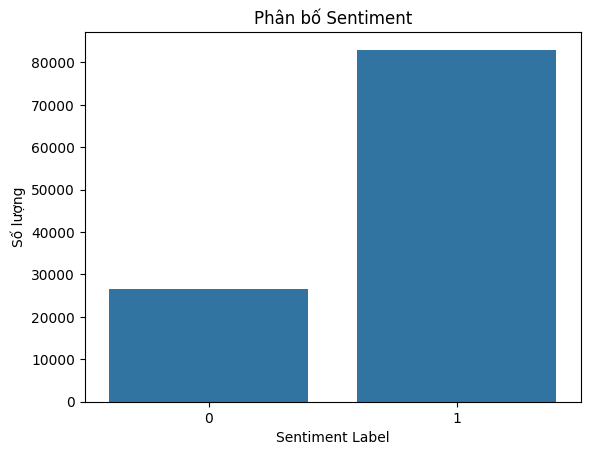

In [ ]:
# Đếm số lượng từng class
label_counts = data['Sentiment_num'].value_counts()

# In ra phân bố
print(label_counts)
print("\nTỷ lệ phần trăm:")
print(label_counts / len(data) * 100)

# Vẽ biểu đồ
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.xlabel("Sentiment Label")
plt.ylabel("Số lượng")
plt.title("Phân bố Sentiment")
plt.show()


In [ ]:
data = data[['review', 'Sentiment_num']]

In [ ]:
data

,review,Sentiment_num
0,i have used restasis for about a year now and ...,0
1,my experience has been somewhat mixed i have b...,1
2,this is my second implanon would not recommend...,0
3,i recommend taking as prescribed and the bottl...,1
4,i have been on ampyra for 5 days and have been...,1
...,...,...
109677,i had tried many medications to level out my b...,1
109678,had partial thyroid removal with benign tumor ...,1
109679,my experience with risperdal started when i fi...,1
109680,my elderly dad was prescribed a low dose of at...,0


In [ ]:
data['Sentiment_num'].value_counts()

,count
Sentiment_num,
1,82994
0,26688


## Split train-test

In [ ]:
# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data['review'], data['Sentiment_num'], test_size=0.2, random_state=42)

# Initializing tokenizers for DistilBERT
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## Data imbalance processing

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hàm synonym replace đơn giản dùng regex tokenizer
def synonym_replace_simple(text):
    # split chỉ lấy các từ, bỏ punctuation
    tokens = re.findall(r"\w+", text)
    # tìm các token có synsets
    candidates = [i for i, w in enumerate(tokens) if wordnet.synsets(w)]
    if not candidates:
        return text
    idx = random.choice(candidates)
    syns = [
        lemma.name()
        for syn in wordnet.synsets(tokens[idx])
        for lemma in syn.lemmas()
        if lemma.name().lower() != tokens[idx].lower()
    ]
    if syns:
        tokens[idx] = random.choice(syns)
    return " ".join(tokens)

# 1) Split data
X_train, X_test, y_train, y_test = train_test_split(
    data['review'], data['Sentiment_num'],
    test_size=0.2, random_state=42
)

# 2) Initial class counts
unique, counts = np.unique(y_train, return_counts=True)
print("Before augmentation:", dict(zip(unique, counts)))

# 3) Compute class weights
class_counts = torch.tensor(counts, dtype=torch.float)
class_weights = (1.0 / class_counts)
class_weights = class_weights / class_weights.sum() * len(class_counts)
print("Class weights:", class_weights.tolist())

# 4) Base weighted CrossEntropyLoss
base_loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights.to(device))

# 5) Data Augmentation on minority class (label=0)
minority_texts = list(X_train[y_train == 0])
n_each = len(minority_texts) // 3
aug_texts = []

# 5a) Back-translation
for _ in tqdm(range(n_each), desc="Back-translation"):
    txt = random.choice(minority_texts)
    try:
        fr = GoogleTranslator(source='en', target='fr').translate(txt)
        en = GoogleTranslator(source='fr', target='en').translate(fr)
        aug_texts.append(en)
    except:
        continue



Before augmentation: {np.int64(0): np.int64(21427), np.int64(1): np.int64(66318)}
Class weights: [1.5116075277328491, 0.48839253187179565]


Back-translation:   0%|          | 0/7142 [00:00<?, ?it/s]

In [ ]:
# 5b) Synonym replacement (simple regex version)
for _ in tqdm(range(n_each), desc="Synonym Augmentation"):
    txt = random.choice(minority_texts)
    aug_texts.append(synonym_replace_simple(txt))

# 5c) EDA (random swap)
eda_aug = naw.RandomWordAug(action="swap")
for _ in tqdm(range(n_each), desc="EDA Augmentation"):
    txt = random.choice(minority_texts)
    aug_texts.append(eda_aug.augment(txt))

print(f"Total augmented samples: {len(aug_texts)} (expected {n_each*3})")

# ✅ Lưu toàn bộ aug_texts vào file để không mất nếu máy ngắt
import json
with open("aug_texts_all.json", "w", encoding="utf-8") as f:
    json.dump(aug_texts, f, ensure_ascii=False, indent=2)

# Tiếp tục bước 6 trở đi như cũ:
X_train_aug = list(X_train) + aug_texts
y_train_aug = list(y_train) + [0] * len(aug_texts)

# Ép về str để tokenizer không lỗi
X_train_aug = [str(txt) for txt in X_train_aug]
X_test_list = [str(txt) for txt in X_test]



[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Synonym Augmentation:   0%|          | 0/7142 [00:00<?, ?it/s]

EDA Augmentation:   0%|          | 0/7142 [00:00<?, ?it/s]

Total augmented samples: 21425 (expected 21426)
After augmentation: {np.int64(0): np.int64(42852), np.int64(1): np.int64(66318)}


In [ ]:
print(len(y_train))  # In ra số dòng (review)


109170


In [ ]:
import pandas as pd

# Giả sử X_train, y_train, X_test, y_test đều là list hoặc pandas Series
df_train = pd.DataFrame({'review': X_train, 'label': y_train})
df_test  = pd.DataFrame({'review': X_test,  'label': y_test})

# Lưu file
df_train.to_csv("train_data.csv", index=False, encoding='utf-8')
df_test.to_csv("test_data.csv", index=False, encoding='utf-8')


## Train model
















#Distilbert


## Model BERT

In [ ]:
# 7) Recompute class weights after augmentation
unique2, counts2 = np.unique(y_train_aug, return_counts=True)
print("After augmentation:", dict(zip(unique2, counts2)))
class_counts2 = torch.tensor(counts2, dtype=torch.float, device=device)
class_weights2 = (1.0 / class_counts2)
class_weights2 = class_weights2 / class_weights2.sum() * len(class_counts2)

# 8) Tokenizer & encoding for BERT
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

train_enc = tokenizer(
    X_train_aug,
    truncation=True,
    padding='max_length',
    max_length=128,
    return_tensors='pt'
)
test_enc = tokenizer(
    X_test_list,
    truncation=True,
    padding='max_length',
    max_length=128,
    return_tensors='pt'
)

# 9) Prepare labels & datasets
train_labels = torch.tensor(y_train_aug, dtype=torch.long)
test_labels  = torch.tensor(y_test.values, dtype=torch.long)

train_ds = TensorDataset(
    train_enc['input_ids'],
    train_enc['attention_mask'],
    train_labels
)
test_ds = TensorDataset(
    test_enc['input_ids'],
    test_enc['attention_mask'],
    test_labels
)

# 10) Weighted sampler to address imbalance
sample_weights = class_weights2[train_labels.to(device)]
sampler = WeightedRandomSampler(
    weights=sample_weights.cpu(),
    num_samples=len(sample_weights),
    replacement=True
)

train_loader = DataLoader(
    train_ds,
    batch_size=16,
    sampler=sampler,
    num_workers=2
)
test_loader = DataLoader(
    test_ds,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

# 11) Focal loss
class FocalLoss(torch.nn.Module):
    def __init__(self, gamma=2.0, weight=None):
        super().__init__()
        self.gamma = gamma
        self.weight = weight

    def forward(self, logits, targets):
        ce = torch.nn.functional.cross_entropy(
            logits, targets, weight=self.weight, reduction='none'
        )
        p_t = torch.exp(-ce)
        return ((1 - p_t) ** self.gamma * ce).mean()

loss_fn = FocalLoss(gamma=2.0, weight=class_weights2)

# 12) Model & optimizer
bert_model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2
).to(device)
optimizer_bert = AdamW(bert_model.parameters(), lr=2e-5)

# 13) Training loop
def train_model(model, loader, optimizer, loss_fn, epochs=3):
    model.train()
    for epoch in range(1, epochs + 1):
        total_loss = 0.0
        loop = tqdm(loader, desc=f"Epoch {epoch}", leave=False)
        for input_ids, attn_mask, labels in loop:
            input_ids = input_ids.to(device)
            attn_mask = attn_mask.to(device)
            labels    = labels.to(device)

            logits = model(input_ids=input_ids, attention_mask=attn_mask).logits
            loss   = loss_fn(logits, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        print(f"[Epoch {epoch}] Avg Loss: {total_loss / len(loader):.4f}")

# 14) Evaluation loop
def evaluate_model(model, loader):
    model.eval()
    all_probs, all_preds, all_labels = [], [], []
    with torch.no_grad():
        for input_ids, attn_mask, labels in loader:
            input_ids = input_ids.to(device)
            attn_mask = attn_mask.to(device)

            logits = model(input_ids=input_ids, attention_mask=attn_mask).logits
            probs  = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()
            preds  = torch.argmax(logits, dim=1).cpu().numpy()

            all_probs.extend(probs)
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())

    return np.array(all_probs), np.array(all_preds), np.array(all_labels)

# 15) Run training & evaluation
print("Training BERT...")
train_model(bert_model, train_loader, optimizer_bert, loss_fn, epochs=3)

probs, preds, labels = evaluate_model(bert_model, test_loader)

# 16) Metrics reporting
print(classification_report(labels, preds, digits=4))
auc_score = roc_auc_score(labels, probs)
gini      = 2 * auc_score - 1
cm        = confusion_matrix(labels, preds)

print(f"AUC:               {auc_score:.4f}")
print(f"Gini:              {gini:.4f}")
print("Confusion Matrix:")
print(cm)

After augmentation: {np.int64(0): np.int64(42852), np.int64(1): np.int64(66318)}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training BERT...


Epoch 1:   0%|          | 0/6824 [00:00<?, ?it/s]

[Epoch 1] Avg Loss: 0.0549


Epoch 2:   0%|          | 0/6824 [00:00<?, ?it/s]

[Epoch 2] Avg Loss: 0.0309


Epoch 3:   0%|          | 0/6824 [00:00<?, ?it/s]

[Epoch 3] Avg Loss: 0.0209
              precision    recall  f1-score   support

           0     0.7976    0.8734    0.8338      5261
           1     0.9588    0.9301    0.9442     16676

    accuracy                         0.9165     21937
   macro avg     0.8782    0.9017    0.8890     21937
weighted avg     0.9202    0.9165    0.9177     21937

AUC:               0.9661
Gini:              0.9321
Confusion Matrix:
[[ 4595   666]
 [ 1166 15510]]


## Result

In [ ]:
balanced_acc_sklearn = balanced_accuracy_score(y_true, y_pred)
print(f"Balanced Accuracy (sklearn): {balanced_acc_sklearn:.4f}")


Recall for class 0: 0.8734
Recall for class 1: 0.9301
Balanced Accuracy (manual): 0.9017
Balanced Accuracy (sklearn): 0.9017


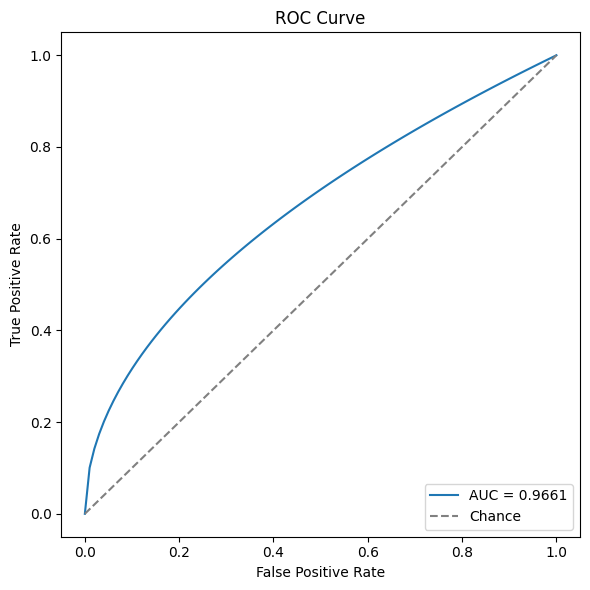

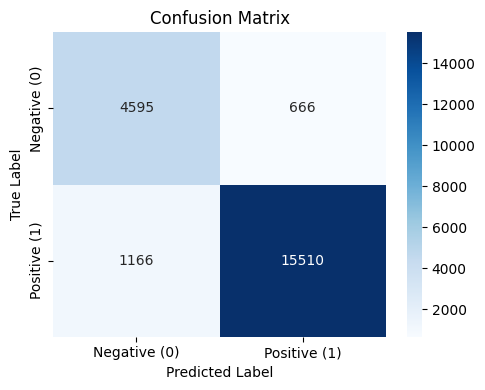

In [ ]:

# 1) Plot ROC curve
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {auc_value:.4f}")
plt.plot([0,1], [0,1], linestyle='--', color='gray', label="Chance")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# 2) Confusion matrix
cm = np.array([[4595,  666],
               [1166,15510]])
labels_cm = ["Negative (0)", "Positive (1)"]

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels_cm, yticklabels=labels_cm)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()
